In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import hamiltonian_monte_carlo as hmc
import diagnostics
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import pickle

import pystan
import stan_utility

In [10]:
DEFAULT_COLORMAP = 'Paired'


def sample_and_plot(sample_generating_function, num_chains, log_density,
                    first_param_limits, second_param_limits, suptitle='', 
                    warmup_proportion=0.5, colormap_name=DEFAULT_COLORMAP):
    all_samples = []
    all_theta_samples = []
    
    for i in range(num_chains):
        samples = sample_generating_function()
        all_samples.append(np.copy(samples))
        theta_samples = np.stack(np.ndarray.flatten(samples[:, 0]))
        all_theta_samples.append(np.copy(theta_samples))
        
    two_d_countour_plot(log_density, num_chains, first_param_limits, second_param_limits,
                        all_samples, all_theta_samples, suptitle, warmup_proportion, colormap_name)
    
    return all_samples, all_theta_samples


def two_d_countour_plot(log_density, num_chains, first_param_limits, second_param_limits,
                        all_samples, all_theta_samples, suptitle='', warmup_propotion=0.5,
                        colormap_name=DEFAULT_COLORMAP):
    theta_one_values = np.linspace(first_param_limits[0], first_param_limits[1], 100)
    theta_two_values = np.linspace(second_param_limits[0], second_param_limits[1], 100)
    
    theta_one_grid, theta_two_grid = np.meshgrid(theta_one_values, theta_two_values)
    theta_grid = np.stack((theta_one_grid, theta_two_grid), axis=2)
    contour_values = log_density(theta_grid)
    
    real_sample_start = int(all_theta_samples[0].shape[0] * warmup_propotion)
        
    colormap = plt.get_cmap(colormap_name)
    plt.figure(figsize=(12, 12))
    plt.contour(theta_one_grid, theta_two_grid, contour_values, 30)
    for i in range(num_chains):
        sample_colors = all_samples[i][:,1].astype(np.int32) + (2 * i)
        sample_colors = [colormap.colors[x] for x in sample_colors]
        plt.scatter(all_theta_samples[i][real_sample_start:,0], 
                    all_theta_samples[i][real_sample_start:,1], 
                    c=sample_colors[real_sample_start:], label=f'Chain #{i+1}')
        
    legend = plt.legend(loc='best')
    for i in range(num_chains):
        legend.legendHandles[i].set_color(colormap.colors[(2 * i) + 1])
        
    theta_samples = np.asarray(all_theta_samples)[:, real_sample_start:, :]
    ess = diagnostics.effective_sample_size(theta_samples)
    rhat = diagnostics.split_r_hat(theta_samples)
    
    with np.printoptions(precision=5, suppress=True):
        plt.title(f'Sampling results, {all_theta_samples[0].shape[0] - real_sample_start} post-warm-up samples, ESS = {ess}, $\\hat{{R}}$ = {rhat}')
    
    plt.suptitle(suptitle, size=20, y=0.93)
    
    plt.show()

In [11]:
def two_d_mixture_gaussians(theta):
    return hmc.np.log(0.5 * hmc.stats.multivariate_normal.pdf(theta, mean=hmc.np.array([2, 12]),
                                                          cov=hmc.np.array(([[2, 0.5], [0.5, 1]]))) + \
                  0.25 * hmc.stats.multivariate_normal.pdf(theta, mean=hmc.np.array([10, -8]),
                                                           cov=hmc.np.array(([[1, 0.9], [0.9, 2]]))) + \
                  0.25 * hmc.stats.multivariate_normal.pdf(theta, mean=hmc.np.array([-12, -9]),
                                                           cov=hmc.np.array(([[0.5, 0], [0, 0.5]]))))

Metropolis-Hastings: sampling 2000 iterations
Sampled 400 iterations of which 240 were accepted
Sampled 800 iterations of which 457 were accepted
Sampled 1200 iterations of which 675 were accepted
Sampled 1600 iterations of which 918 were accepted
Metropolis-Hastings: sampling 2000 iterations
Sampled 400 iterations of which 184 were accepted
Sampled 800 iterations of which 347 were accepted
Sampled 1200 iterations of which 513 were accepted
Sampled 1600 iterations of which 688 were accepted


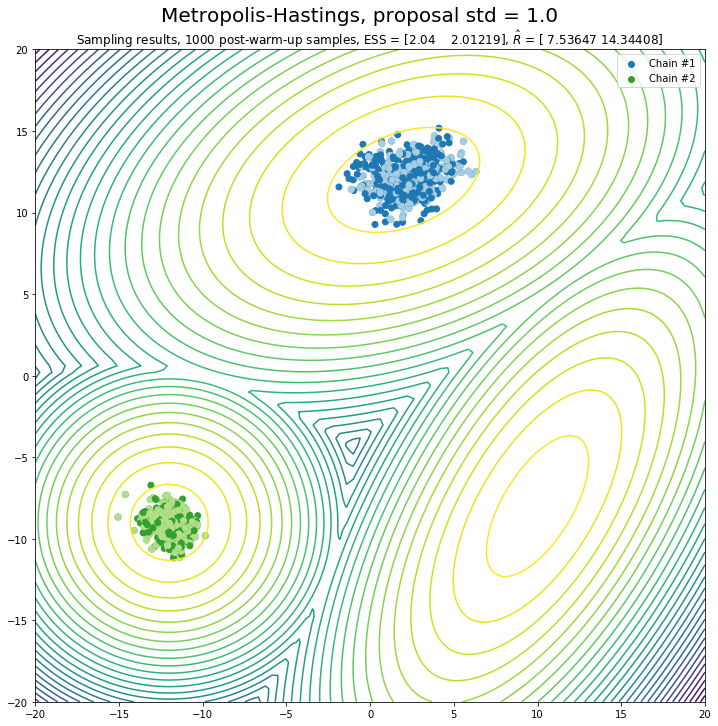

In [12]:
theta_0_sampler = lambda: np.random.uniform(-10, 10, 2)
# results = {}

proposal_std =  1.0

def sample():
    return hmc.metropolis_hastings(two_d_mixture_gaussians, theta_0_sampler(), 
                                   2000, 2, proposal_std, log_interval=400)

all_samples, all_theta_samples = \
    sample_and_plot(sample, 2, two_d_mixture_gaussians, [-20, 20], [-20, 20], 
                   f'Metropolis-Hastings, proposal std = {proposal_std}')

with open('results.pickle', 'rb') as f:
        results = pickle.load(f)

results['MH', proposal_std] = all_samples, all_theta_samples

with open('results.pickle', 'wb') as f:
    pickle.dump(results, f)

Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 138 were accepted
Sampled 800 iterations of which 276 were accepted
Sampled 1200 iterations of which 405 were accepted
Sampled 1600 iterations of which 549 were accepted
Sampled 2000 iterations of which 672 were accepted
Sampled 2400 iterations of which 807 were accepted
Sampled 2800 iterations of which 938 were accepted
Sampled 3200 iterations of which 1077 were accepted
Sampled 3600 iterations of which 1194 were accepted
Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 120 were accepted
Sampled 800 iterations of which 242 were accepted
Sampled 1200 iterations of which 360 were accepted
Sampled 1600 iterations of which 464 were accepted
Sampled 2000 iterations of which 574 were accepted
Sampled 2400 iterations of which 694 were accepted
Sampled 2800 iterations of which 806 were accepted
Sampled 3200 iterations of which 921 were accepted
Sampled 3600 iterations of which 1040 were 

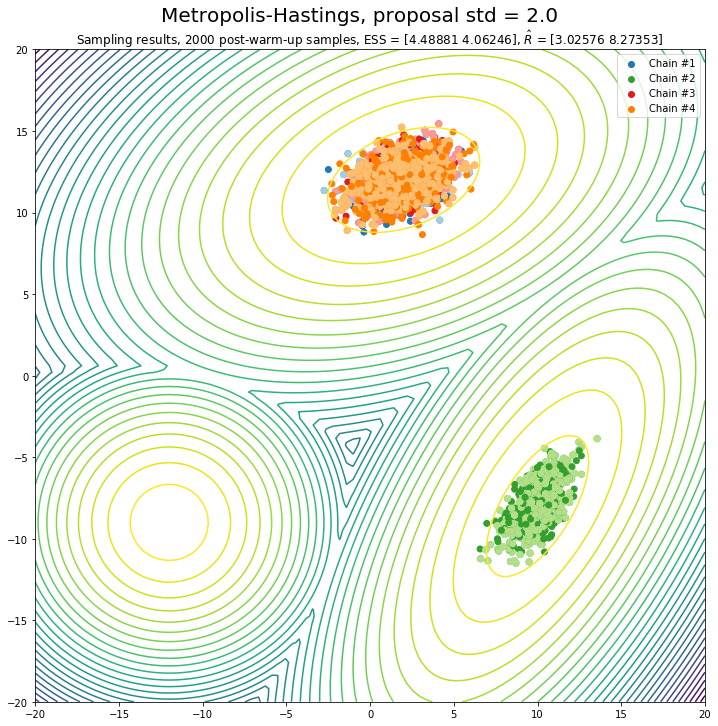

In [15]:
theta_0_sampler = lambda: np.random.uniform(-10, 10, 2)
# results = {}

proposal_std =  2.0

def sample():
    return hmc.metropolis_hastings(two_d_mixture_gaussians, theta_0_sampler(), 
                                   4000, 2, proposal_std, log_interval=400)

all_samples, all_theta_samples = \
    sample_and_plot(sample, 4, two_d_mixture_gaussians, [-20, 20], [-20, 20], 
                   f'Metropolis-Hastings, proposal std = {proposal_std}')

with open('results.pickle', 'rb') as f:
        results = pickle.load(f)

results['MH', proposal_std] = all_samples, all_theta_samples

with open('results.pickle', 'wb') as f:
    pickle.dump(results, f)

Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 35 were accepted
Sampled 800 iterations of which 54 were accepted
Sampled 1200 iterations of which 75 were accepted
Sampled 1600 iterations of which 105 were accepted
Sampled 2000 iterations of which 123 were accepted
Sampled 2400 iterations of which 145 were accepted
Sampled 2800 iterations of which 173 were accepted
Sampled 3200 iterations of which 201 were accepted
Sampled 3600 iterations of which 218 were accepted
Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 71 were accepted
Sampled 800 iterations of which 131 were accepted
Sampled 1200 iterations of which 174 were accepted
Sampled 1600 iterations of which 220 were accepted
Sampled 2000 iterations of which 271 were accepted
Sampled 2400 iterations of which 348 were accepted
Sampled 2800 iterations of which 401 were accepted
Sampled 3200 iterations of which 449 were accepted
Sampled 3600 iterations of which 505 were accepte

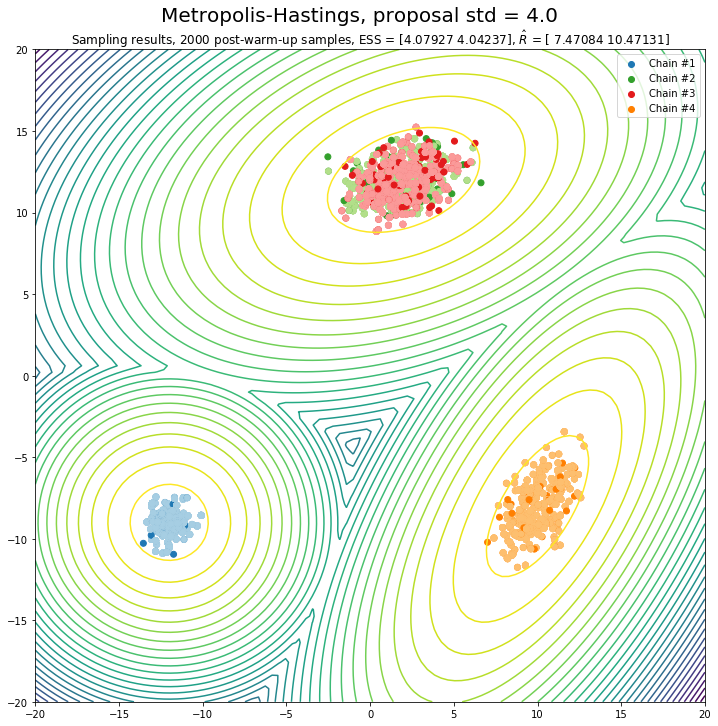

In [16]:
theta_0_sampler = lambda: np.random.uniform(-10, 10, 2)
# results = {}

proposal_std =  4.0

def sample():
    return hmc.metropolis_hastings(two_d_mixture_gaussians, theta_0_sampler(), 
                                   4000, 2, proposal_std, log_interval=400)

all_samples, all_theta_samples = \
    sample_and_plot(sample, 4, two_d_mixture_gaussians, [-20, 20], [-20, 20], 
                   f'Metropolis-Hastings, proposal std = {proposal_std}')

with open('results.pickle', 'rb') as f:
        results = pickle.load(f)

results['MH', proposal_std] = all_samples, all_theta_samples

with open('results.pickle', 'wb') as f:
    pickle.dump(results, f)

## Let's try starting at 0, 0 every time and see what happens

Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 47 were accepted
Sampled 800 iterations of which 92 were accepted
Sampled 1200 iterations of which 135 were accepted
Sampled 1600 iterations of which 179 were accepted
Sampled 2000 iterations of which 228 were accepted
Sampled 2400 iterations of which 275 were accepted
Sampled 2800 iterations of which 318 were accepted
Sampled 3200 iterations of which 350 were accepted
Sampled 3600 iterations of which 397 were accepted
Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 45 were accepted
Sampled 800 iterations of which 95 were accepted
Sampled 1200 iterations of which 152 were accepted
Sampled 1600 iterations of which 196 were accepted
Sampled 2000 iterations of which 249 were accepted
Sampled 2400 iterations of which 305 were accepted
Sampled 2800 iterations of which 364 were accepted
Sampled 3200 iterations of which 416 were accepted
Sampled 3600 iterations of which 465 were accepte

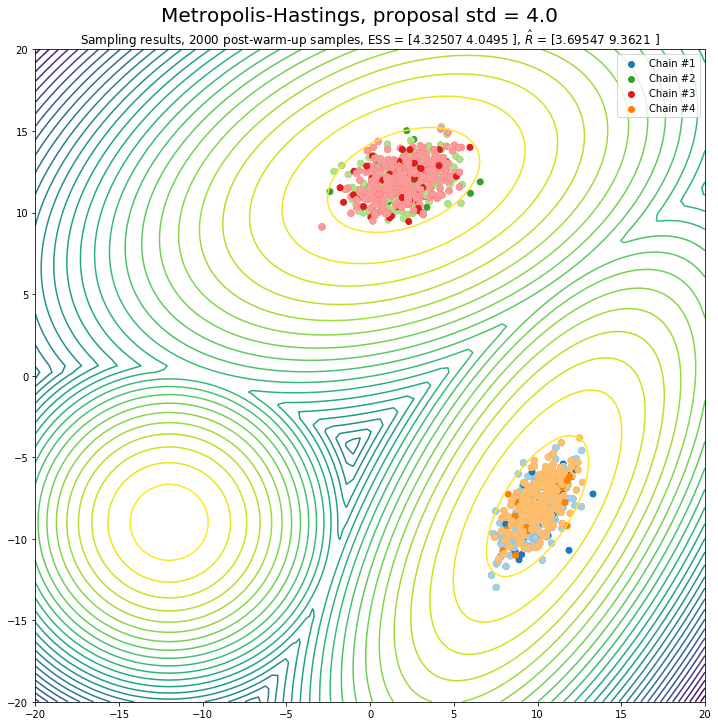

In [17]:
theta_0_sampler = lambda: [0, 0]
# results = {}

proposal_std =  4.0

def sample():
    return hmc.metropolis_hastings(two_d_mixture_gaussians, theta_0_sampler(), 
                                   4000, 2, proposal_std, log_interval=400)

all_samples, all_theta_samples = \
    sample_and_plot(sample, 4, two_d_mixture_gaussians, [-20, 20], [-20, 20], 
                   f'Metropolis-Hastings, proposal std = {proposal_std}')

with open('results.pickle', 'rb') as f:
        results = pickle.load(f)

results['MH', proposal_std] = all_samples, all_theta_samples

with open('results.pickle', 'wb') as f:
    pickle.dump(results, f)

## Let's play with the temperature here as well:

Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 186 were accepted
Sampled 800 iterations of which 366 were accepted
Sampled 1200 iterations of which 543 were accepted
Sampled 1600 iterations of which 737 were accepted
Sampled 2000 iterations of which 911 were accepted
Sampled 2400 iterations of which 1115 were accepted
Sampled 2800 iterations of which 1302 were accepted
Sampled 3200 iterations of which 1495 were accepted
Sampled 3600 iterations of which 1680 were accepted
Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 121 were accepted
Sampled 800 iterations of which 227 were accepted
Sampled 1200 iterations of which 345 were accepted
Sampled 1600 iterations of which 459 were accepted
Sampled 2000 iterations of which 566 were accepted
Sampled 2400 iterations of which 689 were accepted
Sampled 2800 iterations of which 809 were accepted
Sampled 3200 iterations of which 919 were accepted
Sampled 3600 iterations of which 1049 wer

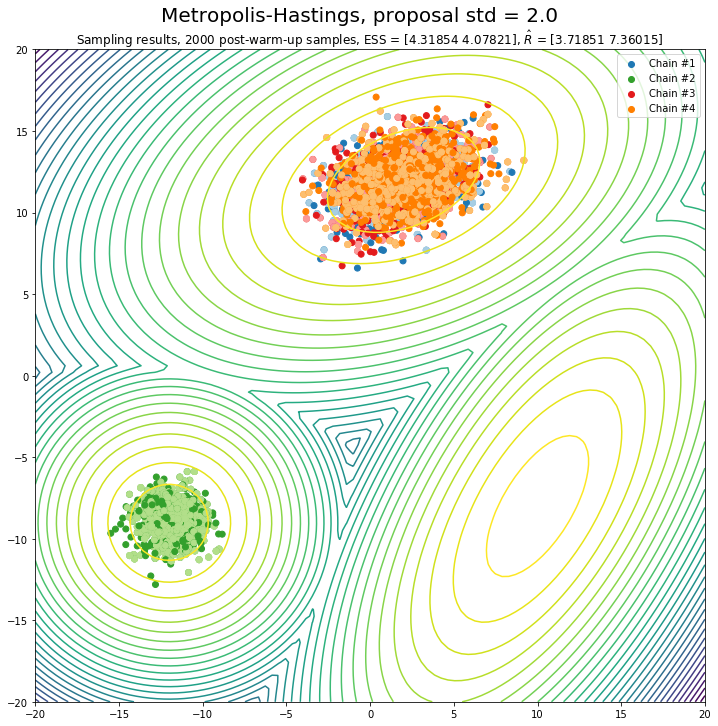

Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 246 were accepted
Sampled 800 iterations of which 475 were accepted
Sampled 1200 iterations of which 709 were accepted
Sampled 1600 iterations of which 928 were accepted
Sampled 2000 iterations of which 1157 were accepted
Sampled 2400 iterations of which 1387 were accepted
Sampled 2800 iterations of which 1603 were accepted
Sampled 3200 iterations of which 1837 were accepted
Sampled 3600 iterations of which 2061 were accepted
Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 226 were accepted
Sampled 800 iterations of which 450 were accepted
Sampled 1200 iterations of which 666 were accepted
Sampled 1600 iterations of which 872 were accepted
Sampled 2000 iterations of which 1090 were accepted
Sampled 2400 iterations of which 1327 were accepted
Sampled 2800 iterations of which 1545 were accepted
Sampled 3200 iterations of which 1747 were accepted
Sampled 3600 iterations of which 197

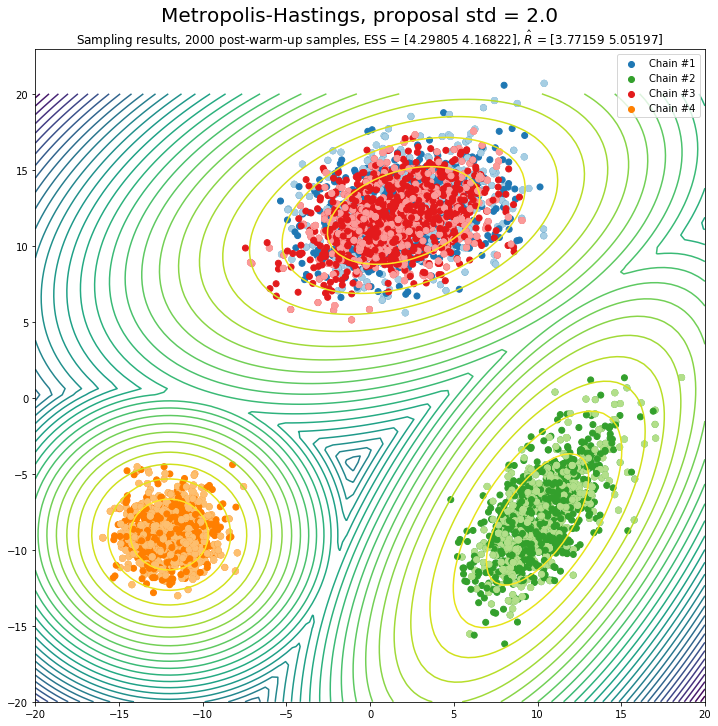

Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 278 were accepted
Sampled 800 iterations of which 541 were accepted
Sampled 1200 iterations of which 819 were accepted
Sampled 1600 iterations of which 1090 were accepted
Sampled 2000 iterations of which 1373 were accepted
Sampled 2400 iterations of which 1655 were accepted
Sampled 2800 iterations of which 1932 were accepted
Sampled 3200 iterations of which 2215 were accepted
Sampled 3600 iterations of which 2505 were accepted
Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 250 were accepted
Sampled 800 iterations of which 509 were accepted
Sampled 1200 iterations of which 758 were accepted
Sampled 1600 iterations of which 1015 were accepted
Sampled 2000 iterations of which 1282 were accepted
Sampled 2400 iterations of which 1543 were accepted
Sampled 2800 iterations of which 1826 were accepted
Sampled 3200 iterations of which 2096 were accepted
Sampled 3600 iterations of which 2

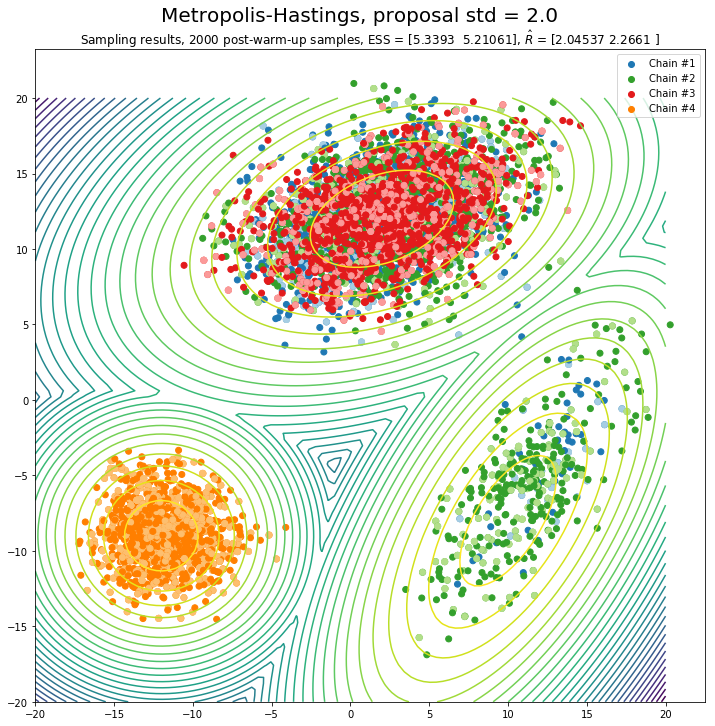

Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 287 were accepted
Sampled 800 iterations of which 568 were accepted
Sampled 1200 iterations of which 815 were accepted
Sampled 1600 iterations of which 1095 were accepted
Sampled 2000 iterations of which 1372 were accepted
Sampled 2400 iterations of which 1665 were accepted
Sampled 2800 iterations of which 1958 were accepted
Sampled 3200 iterations of which 2245 were accepted
Sampled 3600 iterations of which 2535 were accepted
Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 304 were accepted
Sampled 800 iterations of which 636 were accepted
Sampled 1200 iterations of which 924 were accepted
Sampled 1600 iterations of which 1221 were accepted
Sampled 2000 iterations of which 1524 were accepted
Sampled 2400 iterations of which 1819 were accepted
Sampled 2800 iterations of which 2125 were accepted
Sampled 3200 iterations of which 2391 were accepted
Sampled 3600 iterations of which 2

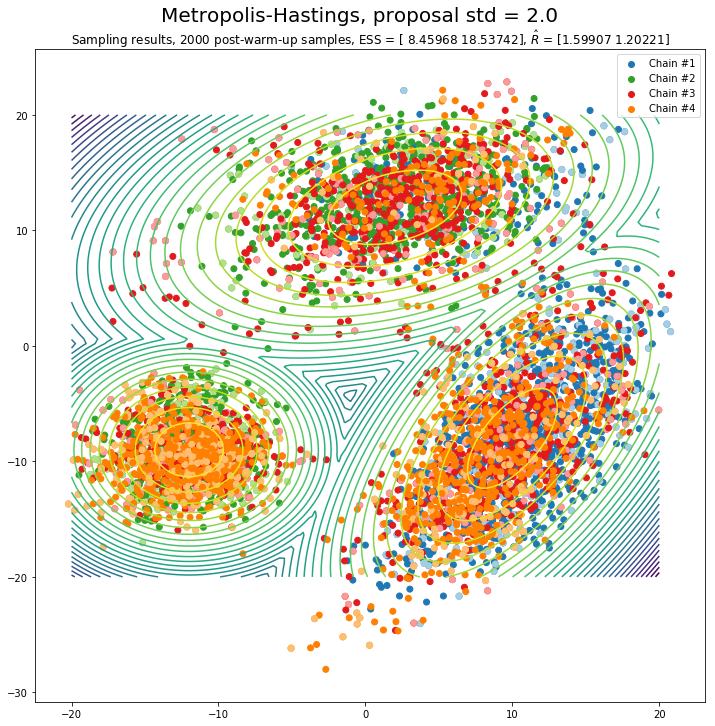

In [19]:
theta_0_sampler = lambda: np.random.uniform(-10, 10, 2)

proposal_std = 2.0

for temperature in (2.0, 4.0, 8.0, 16.0):
    def sample():
        return hmc.metropolis_hastings(two_d_mixture_gaussians, theta_0_sampler(), 
                                       4000, 2, proposal_std, temperature, log_interval=400)

    all_samples, all_theta_samples = \
        sample_and_plot(sample, 4, two_d_mixture_gaussians, [-20, 20], [-20, 20], 
                       f'Metropolis-Hastings, proposal std = {proposal_std}')

    with open('results.pickle', 'rb') as f:
        results = pickle.load(f)

    results['MH', proposal_std, temperature] = all_samples, all_theta_samples
    
    with open('results.pickle', 'wb') as f:
        pickle.dump(results, f)

## Trying a sinusodial temperature annealing schedule

Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 292 were accepted
Sampled 800 iterations of which 528 were accepted
Sampled 1200 iterations of which 741 were accepted
Sampled 1600 iterations of which 1042 were accepted
Sampled 2000 iterations of which 1256 were accepted
Sampled 2400 iterations of which 1487 were accepted
Sampled 2800 iterations of which 1754 were accepted
Sampled 3200 iterations of which 1950 were accepted
Sampled 3600 iterations of which 2216 were accepted
Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 242 were accepted
Sampled 800 iterations of which 408 were accepted
Sampled 1200 iterations of which 576 were accepted
Sampled 1600 iterations of which 823 were accepted
Sampled 2000 iterations of which 985 were accepted
Sampled 2400 iterations of which 1200 were accepted
Sampled 2800 iterations of which 1456 were accepted
Sampled 3200 iterations of which 1602 were accepted
Sampled 3600 iterations of which 186

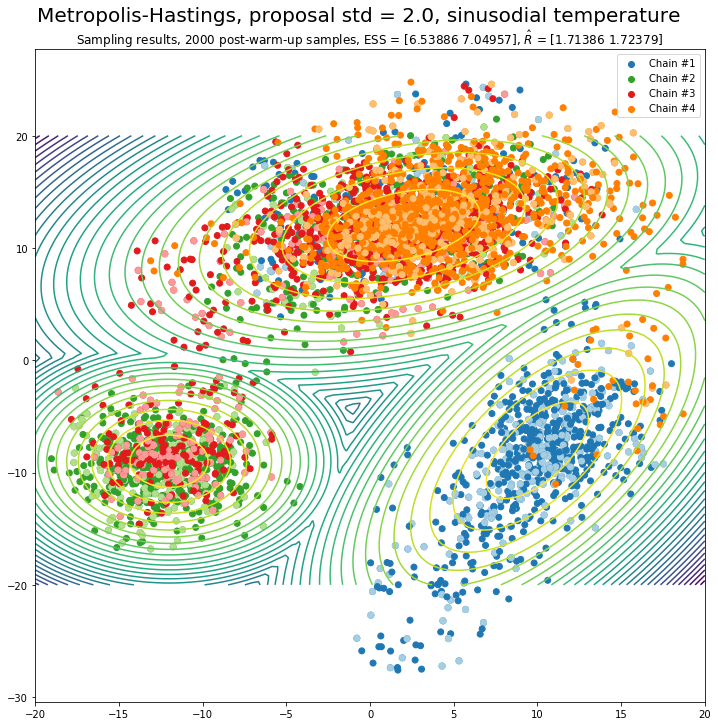

In [44]:
def sinusodial_temperature(i):
    return (np.sin(i / 100) + 1) * 10

theta_0_sampler = lambda: np.random.uniform(-10, 10, 2)

proposal_std = 2.0

def sample():
    return hmc.metropolis_hastings(two_d_mixture_gaussians, theta_0_sampler(), 
                                   4000, 2, proposal_std, sinusodial_temperature, log_interval=400)

all_samples, all_theta_samples = \
    sample_and_plot(sample, 4, two_d_mixture_gaussians, [-20, 20], [-20, 20], 
                   f'Metropolis-Hastings, proposal std = {proposal_std}, sinusodial temperature')

with open('results.pickle', 'rb') as f:
    results = pickle.load(f)

results['MH', proposal_std, 'sinusodial temp'] = all_samples, all_theta_samples

with open('results.pickle', 'wb') as f:
    pickle.dump(results, f)

What if we now lower the proposal $\sigma$?

Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 355 were accepted
Sampled 800 iterations of which 631 were accepted
Sampled 1200 iterations of which 888 were accepted
Sampled 1600 iterations of which 1250 were accepted
Sampled 2000 iterations of which 1541 were accepted
Sampled 2400 iterations of which 1834 were accepted
Sampled 2800 iterations of which 2188 were accepted
Sampled 3200 iterations of which 2458 were accepted
Sampled 3600 iterations of which 2789 were accepted
Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 325 were accepted
Sampled 800 iterations of which 562 were accepted
Sampled 1200 iterations of which 815 were accepted
Sampled 1600 iterations of which 1152 were accepted
Sampled 2000 iterations of which 1382 were accepted
Sampled 2400 iterations of which 1677 were accepted
Sampled 2800 iterations of which 2029 were accepted
Sampled 3200 iterations of which 2300 were accepted
Sampled 3600 iterations of which 2

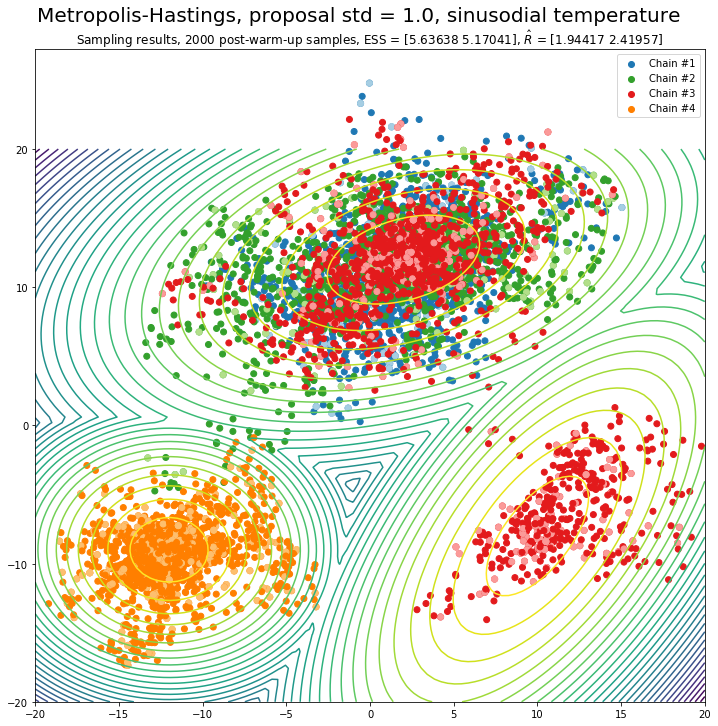

In [45]:
def sinusodial_temperature(i):
    return (np.sin(i / 100) + 1) * 10

theta_0_sampler = lambda: np.random.uniform(-10, 10, 2)

proposal_std = 1.0

def sample():
    return hmc.metropolis_hastings(two_d_mixture_gaussians, theta_0_sampler(), 
                                   4000, 2, proposal_std, sinusodial_temperature, log_interval=400)

all_samples, all_theta_samples = \
    sample_and_plot(sample, 4, two_d_mixture_gaussians, [-20, 20], [-20, 20], 
                   f'Metropolis-Hastings, proposal std = {proposal_std}, sinusodial temperature')

with open('results.pickle', 'rb') as f:
    results = pickle.load(f)

results['MH', proposal_std, 'sinusodial temp'] = all_samples, all_theta_samples

with open('results.pickle', 'wb') as f:
    pickle.dump(results, f)

Interestingly, this results in lower ESS and $\hat{R}$ -- let's try a different tweak:

Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 268 were accepted
Sampled 800 iterations of which 459 were accepted
Sampled 1200 iterations of which 641 were accepted
Sampled 1600 iterations of which 919 were accepted
Sampled 2000 iterations of which 1098 were accepted
Sampled 2400 iterations of which 1298 were accepted
Sampled 2800 iterations of which 1550 were accepted
Sampled 3200 iterations of which 1680 were accepted
Sampled 3600 iterations of which 1915 were accepted
Metropolis-Hastings: sampling 4000 iterations
Sampled 400 iterations of which 253 were accepted
Sampled 800 iterations of which 447 were accepted
Sampled 1200 iterations of which 635 were accepted
Sampled 1600 iterations of which 893 were accepted
Sampled 2000 iterations of which 1070 were accepted
Sampled 2400 iterations of which 1291 were accepted
Sampled 2800 iterations of which 1546 were accepted
Sampled 3200 iterations of which 1704 were accepted
Sampled 3600 iterations of which 193

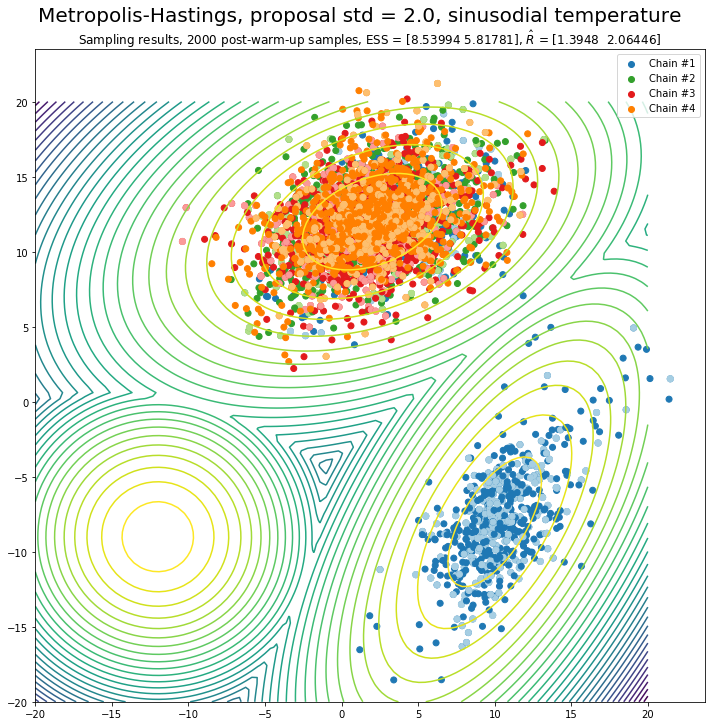

In [46]:
def sinusodial_temperature(i):
    return (np.sin(i / 100) + 1) * 5

theta_0_sampler = lambda: np.random.uniform(-10, 10, 2)

proposal_std = 2.0

def sample():
    return hmc.metropolis_hastings(two_d_mixture_gaussians, theta_0_sampler(), 
                                   4000, 2, proposal_std, sinusodial_temperature, log_interval=400)

all_samples, all_theta_samples = \
    sample_and_plot(sample, 4, two_d_mixture_gaussians, [-20, 20], [-20, 20], 
                   f'Metropolis-Hastings, proposal std = {proposal_std}, sinusodial temperature')

with open('results.pickle', 'rb') as f:
    results = pickle.load(f)

results['MH', proposal_std, 'alternative sinusodial temp'] = all_samples, all_theta_samples

with open('results.pickle', 'wb') as f:
    pickle.dump(results, f)

Performs better on some metrics, but misses one of the modes completley